## QUESTIONS:

PART 1: 
Write a Python function that takes the name of a star and returns a galpy Orbit object (setup with the star's position, distance, proper motion, and radial velocity). Apply to: GJ 440, Lacaille 8760, Vega. Check that you are finding the right star.

PART 2: 
Match the APOGEE-red-clump catalog to Gaia DR2, integrate the orbits using galpy for 20 Gyr, and make a density plot in Galactocentric X and Y coordinates of all of the positions of the stars over the next 20 Gyr.

PART 3: 
Write a function that takes (ra,dec,distance,proper motion ra,proper motion dec,line-of-sight velocity) and their Gaussian uncertainties for a star and computes eccentricity, zmax, rperi, rap and their uncertainties using Monte Carlo sampling with the galpy function galpy.actionAngle.actionAngleStaeckel.EccZmaxRperiRap. Apply to some stars in the Gaia RV sample. 


## SOLUTIONS:

PART 1:

Input name of star. We want to test 3 stars: GJ 440, Lacaille 8760, and Vega. Of course, our function will be generalized to any star identifiable by SIMBAD (Set of Identifications, Measurements, and Bibliography for Astronomical Data)

In [119]:
# starname = input("Input star name to return as galpy Orbit object")
# Testing Examples:
starnames = ["GJ 440", "Lacaille 8760", "Vega"]

In [115]:
# importing necessary modules in the order used
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.gaia import Gaia
from galpy.orbit import Orbit

Algorithm:

1) Setup SIMBAD search to also accept: parallax, proper motion (right ascention direction), proper motion (declination direction) and radial velocity using add_votable_fields (VOTable - Virtual Observatory Table)

2) Given name of star, identify star in SIMBAD database using the query_object function and retrieve info.


3) Since SIMBAD returns RA & DEC in hours/mins/seconds & degrees/arcminutes/arcseconds respectively, we use Skycoord to convert both into float degrees (ICRS (International Celestial Reference System) units) as that is what a galpy Orbit object requires. This makes a Skycoord object.


4) Combine simbad_converted with simbad_info to make simbad_query ready to be queried by ADQL (Astronomical Data Query Language). 6 variables are required for  epoch propagation.


5) In case SIMBAD returns "--" for unknown value, set values to 0.


6) Perform cone search in GAIA DR2 with 0.000001 degrees and using epoch adjustment in ADQL by EPOCH_PROP_POS (we are propagating from 2000 to 2015.5).


7) If Gaia tables are not empty, at least 5 tables (maybe not radial velocity) should have values. If not, use SIMBAD data to make a galpy Orbit object. Either way, if radial velocity data is lacking, set it = 20 km/s.


In [120]:
def starname_to_galpyorbitobject(starname):
    
    simbad_setup = Simbad()  # Step 1
    simbad_setup.add_votable_fields("parallax", "pmra", "pmdec", "rv_value")
    
    simbad_info = simbad_setup.query_object(starname)  # Step 2   
    
    
    simbad_converted = SkyCoord(simbad_info['RA'][0], simbad_info['DEC'][0], # Step 3
                                unit = (u.hourangle, u.deg))  
    
    simbad_query = [simbad_converted.ra.value,  # Step 4
                    simbad_converted.dec.value,
                    simbad_info['PLX_VALUE'][0],
                    simbad_info['PMRA'][0],
                    simbad_info['PMDEC'][0],
                    simbad_info['RV_VALUE'][0]]
    
    
    simbad_query_fixed = []  # Step 5
    for value in simbad_query:
        if str(value) != '--':
            simbad_query_fixed.append(value)
        else:
            simbad_query_fixed.append(0.0)
        
    if simbad_query_fixed[5] == 0.0:
        simbad_query_fixed[5] = 20.0
            
    radius = 0.000001*u.deg  # Step 6
    query =  """
             SELECT source_id, ra, dec, pmra, pmdec, parallax, radial_velocity
             FROM gaiadr2.gaia_source
             WHERE 1=CONTAINS(
             POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),
             CIRCLE('ICRS', 
             COORD1(EPOCH_PROP_POS({0},{1},{2},{3},{4},{5},2000,2015.5)),
             COORD2(EPOCH_PROP_POS({0},{1},{2},{3},{4},{5},2000,2015.5)), {6}))
             """.format(*simbad_query_fixed, radius.value)
    gaiadr2_info = Gaia.launch_job_async(query)
    results = gaiadr2_info.get_results()
    
    if len(results) == 0:  # Step 7
        simbad_query_fixed[2] = 1 / simbad_query_fixed[2]  # parallax to distance
        orbit = Orbit(vxvv = (simbad_query_fixed), radec = True)
        return orbit
    else:
        if results['radial_velocity'][0] == '--':
            results['radial_velocity'][0] = 20
        orbit = Orbit(vxvv = (results['ra'][0],
                              results['dec'][0],
                              1 / results['parallax'][0],
                              results['pmra'][0],
                              results['pmdec'][0],
                              results['radial_velocity'][0]), radec = True)
        return orbit

In [121]:
# testing out inputted stars
for star in starnames:
    orbit = starname_to_galpyorbitobject(star)
    print(type(orbit))
    print("Star:", star)
    print("RA:", orbit.ra(), "deg")
    print("DEC:", orbit.dec(), "deg")
    print("Distance:", orbit.dist(), "kpc")
    print("Proper Motion RA:", orbit.pmra(), "mas/yr")
    print("Proper Motion DEC:", orbit.pmdec(), "deg/yr")
    print("Radial Velocity:", orbit.vlos(), "km/s\n")

Query finished.
<class 'galpy.orbit_src.Orbit.Orbit'>
Star: GJ 440
RA: 176.428816667 deg
DEC: -64.8415166667 deg
Distance: 0.00463434980073 kpc
Proper Motion RA: 2662.036 mas/yr
Proper Motion DEC: -345.182999998 deg/yr
Radial Velocity: 20.0 km/s

Query finished.
<class 'galpy.orbit_src.Orbit.Orbit'>
Star: Lacaille 8760
RA: 319.313619583 deg
DEC: -38.8673597222 deg
Distance: 0.00394617418413 kpc
Proper Motion RA: -3260.29 mas/yr
Proper Motion DEC: -1146.22 deg/yr
Radial Velocity: 20.11 km/s

Query finished.
<class 'galpy.orbit_src.Orbit.Orbit'>
Star: Vega
RA: 279.234734583 deg
DEC: 38.7836888889 deg
Distance: 0.00767872226062 kpc
Proper Motion RA: 200.94 mas/yr
Proper Motion DEC: 286.23 deg/yr
Radial Velocity: -20.6 km/s



PART 2:

In [3]:
# importing necessary modules in the order used, 
# assume modules in PART 1 are still being used
import gaia_tools.load as gload
import numpy as np
from galpy.potential import MWPotential2014
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
# Since I had trouble running my python function to download data online, 
# I manually downloaded APOGEE-RC DR14 and the crossmatched GAIA DR2 stars
# So, this function calls files locally and does not require internet.

rc_cat, gaia2_matches= gload.apogeerc(xmatch='gaiadr2')
# I made changes to gaia_tools/xmatch/__init__.py source file, 
# I changed 'float128' to 'float64' in line64 as I kept getting a float128 error

C:\Users\micha\Anaconda3\lib\site-packages\gaia_tools-0.2-py3.6.egg\gaia_tools\load\__init__.py:114: UserWarning: Falling back on simple APOGEE interface; for more functionality, install the jobovy/apogee package
  warnings.warn("Falling back on simple APOGEE interface; for more functionality, install the jobovy/apogee package")



In [7]:
# This quickly checks how many stars are crossmatched.
counter = 0
for i in gaia2_matches:
    counter +=1
print (counter)

29484


In [113]:
# collect all x & y values of integrated orbits of all crossmatched stars with valid radial velocity

ts = np.linspace(0, 20, 100)*u.Gyr  # to integrate orbits over 20 Billion years
x = []  # store all x points
y = []  # story all y points
counter = 0
for star in range(10):
    # stars with no radial velocity recorded are removed 
    # by default, they are -9999.99 km/s which is obviously incorrect
    if gaia2_matches[star]["radial_velocity"] !=  -9999.99:
        o = Orbit(vxvv=[gaia2_matches[star]["ra_epoch2000"],
                        gaia2_matches[star]["dec_epoch2000"],
                        (1/gaia2_matches[star]["parallax"]),
                        gaia2_matches[star]["pmra"],
                        gaia2_matches[star]["pmdec"],
                        gaia2_matches[star]["radial_velocity"]], 
                        radec = True, ro = 8., vo = 220.)
        o.integrate(ts, MWPotential2014)
        info = o.plot(d1='x',d2='y')
        x_temp, y_temp = info[0].get_data()
        x.extend(x_temp)
        y.extend(y_temp)
        plt.close()

In [9]:
# Since there are many x and y values, save them to a .npy file in case jupyter notebook crashes

np.save('x, y values, 100 step.npy', x, y)

saving...


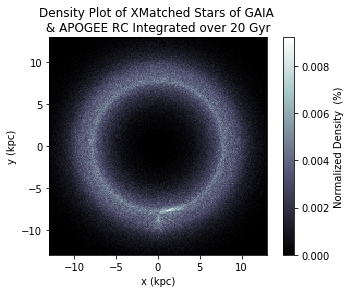

In [112]:
# load (x, y) values saved as a list of tuples
(x, y) = np.load('x, y values, 100 step.npy')

# Make density plot (2D histogram)

hist, x_edges, y_edges = np.histogram2d(x, y, bins = 200, range = [[-13, 13], [-13, 13]], normed = True)
plt.imshow(hist, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], cmap = 'bone')

plt.xlabel("x (kpc)")
plt.ylabel("y (kpc)")

plt.title("Density Plot of XMatched Stars of GAIA \n & APOGEE RC Integrated over 20 Gyr ")
plt.colorbar(label = 'Normalized Density  (%)')
print("saving...")
plt.savefig('density_plot_points_200.pdf')
plt.show()  # note the higher density on the right side of the ring, this is hypothesized to be near the location of the sun, 
            # which is where all most stars start their orbit, since we only know info from the local stars in the Milky Way.

PART 3:

Using PART 1, we can initialize a galpy Orbit object by using the function: starname_to_galpyorbitobject(starname). For propagating uncertainties using the galpy EccZmaxRperiRap, we will manually input errors (from Gaia DR2). A function can be written to query the errors using ADQL but is not the purpose of this question. 

In [201]:
# importing necessary modules in the order used, 
# assume modules in PART 1 & PART 2 are still being used
from astropy.coordinates import ICRS
from astropy.coordinates import Galactic
from galpy.actionAngle import actionAngleStaeckel

# using Lacaille 8760 as all measured errors are available on Gaia DR2
orbit = starname_to_galpyorbitobject("Lacaille 8760")

# to use the numpy function random.multivariate_normal, we need to initialize the mean and covariance of our sample
mean = [orbit.ra(), orbit.dec(), orbit.dist(), orbit.pmra(), orbit.pmdec(), orbit.vlos()]

# manually entered, info from Gaia DR for Lacaille 8760
# this is a diagonal matrix that stores the errors of each orbit value (ex. ra error)
covariance = [[0.0566206585453647, 0, 0, 0, 0, 0], 
             [0, 0.043841161697402424, 0 ,0 ,0 ,0], 
             [0, 0, orbit.dist() * (0.05586746301128440/(1/orbit.dist())), 0, 0, 0],  # orbital distance*(par_error/par)
             [0, 0, 0, 0.09879398867748382, 0 ,0], 
             [0, 0,0 , 0, 0.08222479248276107, 0], 
             [0, 0, 0, 0 ,0 , 0.12656168634819115]]

# generate 50 random samples from a multivariate normal distribution using numpy

x1, x2, x3, x4, x5, x6 = np.random.multivariate_normal(mean, covariance, 100).T


Query finished.


In [202]:
# initializing actionAngleStaeckel function
aAS= actionAngleStaeckel(pot=MWPotential2014,delta=0.4)

# calculating the Ecc, Zmax, Rperi and Rap of star given
Ecc, Zmax, Rperi, Rap = aAS.EccZmaxRperiRap(orbit)

print(Ecc[0], Zmax[0], Rperi[0], Rap[0])



0.233059421623 0.0946153559138 0.786861335404 1.26508729683


In [203]:
# calculating the Ecc, Zmax, Rperi and Rap for random samples

# first we will initialize 100 orbit objects
orbit_list = []
for i in range(100):
    orbit_random = Orbit(vxvv = (x1[i], x2[i],x3[i], x4[i], x5[i], x6[i]), radec = True)
    orbit_list.append(orbit_random)
    
# calculate the Ecc, Zmax, Rperi and Rap of random sample
Ecc_list = []
Zmax_list = []
Rperi_list = []
Rap_list = []
for orbit_random in orbit_list:
    Ecc_random, Zmax_random, Rperi_random, Rap_random = aAS.EccZmaxRperiRap(orbit_random)
    Ecc_list.append(Ecc_random[0])
    Zmax_list.append(Rperi_random[0])
    Rperi_list.append(Rperi_random[0])
    Rap_list.append(Rap_random[0])

# find the standard deviation of each list    
Ecc_std = np.std(Ecc_list)
Zmax_std = np.std(Zmax_list)
Rperi_std = np.std(Rperi_list)
Rap_std = np.std(Rap_list)

In [205]:
# convert values from natural galpy units into physical units and display results:
print("Eccentricity:", Ecc[0], "\nError:", Ecc_std)
print("\nMaximum Z-value (kpc)", Zmax[0] * 8, "\nError (kpc):", Zmax_std * 8)
print("\nPerihelion Radius (kpc)", Rperi[0] * 8, "\nError(kpc):", Rperi_std * 8)
print("\nAphelion Radius (kpc)", Rap[0] * 8, "\nError(kpc):", Rap_std * 8)

Eccentricity: 0.233059421623 
Error: 0.0357997074411

Maximum Z-value (kpc) 0.75692284731 
Error (kpc): 0.322211656288

Perihelion Radius (kpc) 6.29489068323 
Error(kpc): 0.322211656288

Aphelion Radius (kpc) 10.1206983747 
Error(kpc): 0.262073927893
